# DATA51000 Assignment 3: Clustering
#### Lewis University, Summer 1
#### Mathew Golf

In [3]:
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale
import re
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from fcmeans import FCM # install as fuzzy-c-means
from pyclustertend import ivat
from sklearn.decomposition import PCA

In [6]:
# check directory
import os
os.getcwd()

'C:\\Users\\Mathe'

In [8]:
# change directory
os.chdir('C:/Users/Mathe/Desktop/PythonForBiology')
os.getcwd()

'C:\\Users\\Mathe\\Desktop\\PythonForBiology'

In [11]:
# code adapted from: Piotr Grabowski, 03.07.2016 for Kaggle

# set paths to the datasets
dataset_path = "77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "clinical_data_breast_cancer.csv"
pam50_proteins = "PAM50_proteins.csv"

# load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0) # holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

In [13]:
# check the data
data.head()

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [14]:
# clean the data and remove unused columns
data.drop(['gene_symbol', 'gene_name'], axis=1, inplace=True)

# convert protein data names to same clinical data names
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]', x)[0]) if bool(
re.search("TCGA",x)) is True else x,inplace = True)

In [15]:
# transpose the data for clustering to divide patient samples not the proteins
data = data.transpose()
data.head()

RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [16]:
# check data
clinical.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [17]:
# remove clinical entries for the samples not in the protein data
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]

# combine clinical and protein data
processed = data.merge(clinical, left_index=True, right_index=True)

In [18]:
# make sure it worked
processed.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,Luminal A,-7,-5,4,4,ReacI,4,3,1,4


In [19]:
# clean the data - numerical data where NP_xx/XP_xx are protein identifiers for RefSeq
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]

# from this select the PAM50 proteins (known genes used for predicting breast cancer subtype)
processed_numerical_p50 = processed_numerical.iloc[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]

In [20]:
# impute the missing values using the median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(processed_numerical_p50)
processed_numerical_p50 = imputer.transform(processed_numerical_p50)

In [24]:
# check the data
pam50.head()

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


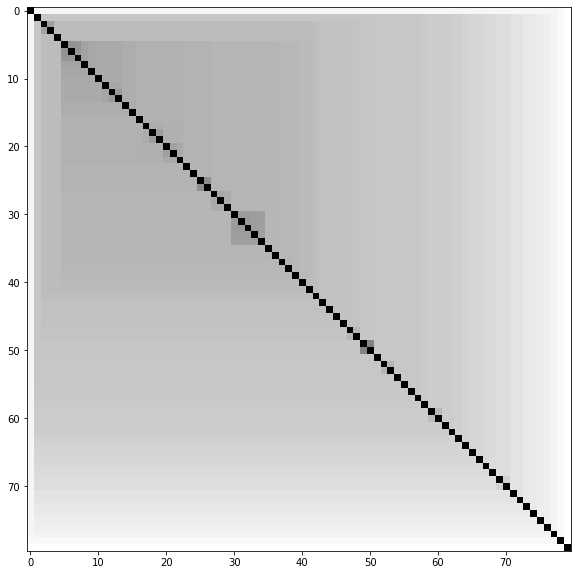

In [25]:
## Pre-clustering using iVAT
# Improved Visual Analysis for Cluster Tendency Assessment (iVAT)
# detects inherent clusters in the data
X = scale(processed_numerical_p50)
ivat(X)

In [26]:
# DataFrame representation of the process_numerical_p50 data which is final version of the data
# this version of the data is talked about in the report for combined data, clinical, and indexed via PAM50
dfp50 = pd.DataFrame(processed_numerical_p50)
dfp50

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,-1.292949,3.541400,3.177722,0.001309,-1.792547,-0.830502,-0.538113,2.516489,2.556897,-2.035927
1,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,1.029442,-0.714133
2,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,-1.410193,0.702364,-1.402538,0.001309,-0.210764,1.934688,-0.538113,0.798041,2.003576,-2.035927
3,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,...,0.018893,-1.574649,-4.515280,0.001309,-0.210764,2.049328,-0.538113,-0.266769,-3.201798,-7.724769
4,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,...,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-2.079011,-3.046991,2.554537,-0.443199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.409316,0.739026,0.943825,1.415596,1.806910,-0.504402,-2.625542,-5.284283,-4.907597,-5.309883,...,-0.248402,-0.295945,-2.307371,4.641193,-1.799029,-0.830502,-0.538113,-2.076972,-0.851830,1.554568
76,-0.415696,-1.232627,-2.823113,1.724231,0.668726,-3.130366,-0.462687,-6.427009,-6.195666,-6.427009,...,-2.320664,-1.232627,-1.438667,0.001309,-0.210764,-0.910915,-0.538113,-0.075910,-0.101213,-7.659635
77,-2.742664,-3.307172,-5.903908,-5.218972,-4.650701,-3.894260,-3.284592,2.861017,3.098110,2.981445,...,-0.202379,-2.772771,-6.268957,1.340609,1.826086,-0.830502,-0.538113,0.395999,-3.962001,-7.804418
78,-0.781777,-1.588474,-3.732945,0.701651,0.213150,-2.531862,-0.277591,-4.456732,-4.665129,-4.665129,...,-2.155403,-0.183476,-0.732478,0.001309,-0.611474,0.690446,-0.538113,-0.061749,3.240507,-2.090419


In [27]:
# guesstimate value of k as iVAT didn't generate clear clusters
n_clusters = [2,3,4,5,6,7,8,9,10,15,30,40,79]

In [30]:
# evaluate our estimated cluster numbers (k) via the silhouette score

# Silhouette Coefficient for a sample is (b - a) / max(a, b)
# mean intra-cluster distance (a)
# mean nearest-cluster distance (b)
# b is the distance between a sample and the nearest cluster that the sample is not a part of

def compare_k_means(k_list,data):
    for k in k_list:
        clusterer = KMeans(n_clusters=k)
        clusterer.fit(data)
        print("Silhouette Score for k == %s: %s" % (
        k, round(metrics.silhouette_score(data, clusterer.labels_),4)))
        print("-------------------------------------")

In [31]:
compare_k_means(n_clusters,processed_numerical_p50)
# clearly k = 2 is the best fit cluster number
# top 3 cluster numbers are: k = 2, 3, 4

Silhouette Score for k == 2: 0.211
-------------------------------------
Silhouette Score for k == 3: 0.1779
-------------------------------------
Silhouette Score for k == 4: 0.1392
-------------------------------------
Silhouette Score for k == 5: 0.1378
-------------------------------------
Silhouette Score for k == 6: 0.1096
-------------------------------------
Silhouette Score for k == 7: 0.1147
-------------------------------------
Silhouette Score for k == 8: 0.1058
-------------------------------------
Silhouette Score for k == 9: 0.1029
-------------------------------------
Silhouette Score for k == 10: 0.0878
-------------------------------------
Silhouette Score for k == 15: 0.0913
-------------------------------------
Silhouette Score for k == 30: 0.0814
-------------------------------------
Silhouette Score for k == 40: 0.0705
-------------------------------------
Silhouette Score for k == 79: 0.0087
-------------------------------------


In [32]:
clusterer_final = KMeans(n_clusters=2) # based on silhouette score, cancer or not
clusterer_final = clusterer_final.fit(processed_numerical_p50)
processed_p50_plot = pd.DataFrame(processed_numerical_p50)
processed_p50_plot['KMeans_cluster'] = clusterer_final.labels_
processed_p50_plot.sort_values('KMeans_cluster',axis=0,inplace=True)

<AxesSubplot:ylabel='Patient'>

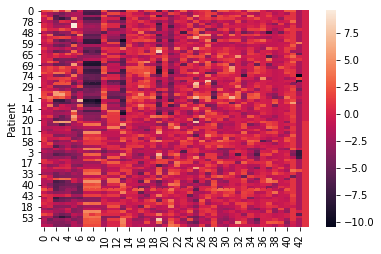

In [33]:
processed_p50_plot.index.name = 'Patient'
sb.heatmap(processed_p50_plot)

In [34]:
processed_p50_plot

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,KMeans_cluster
Patient,,,,,,,,,,,,,,,,,,,,,
0,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,3.541400,3.177722,0.001309,-1.792547,-0.830502,-0.538113,2.516489,2.556897,-2.035927,0
35,-0.619782,-2.061033,-3.475219,-4.530784,-2.822258,-1.705795,-1.678730,-6.827989,-6.973468,-6.834756,...,-1.117115,-2.162530,0.001309,0.635392,-1.553551,-0.538113,-1.871573,1.029442,-2.035927,0
36,1.359573,-1.177327,-6.194613,-3.648293,-2.263673,-1.770736,-1.959120,-2.690676,-2.618462,-2.831964,...,3.585640,-0.882193,0.001309,1.617031,-0.618456,-0.538113,0.618597,1.029442,-2.035927,0
37,-0.488477,2.120020,-5.818289,-7.698595,-5.387528,4.567836,-2.249127,-6.635367,-6.638786,-6.741348,...,0.561075,1.996945,0.001309,0.178177,-0.300447,-2.874756,0.896111,1.029442,-2.035927,0
78,-0.781777,-1.588474,-3.732945,0.701651,0.213150,-2.531862,-0.277591,-4.456732,-4.665129,-4.665129,...,-0.183476,-0.732478,0.001309,-0.611474,0.690446,-0.538113,-0.061749,3.240507,-2.090419,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,1.882713,0.999190,-3.354167,-4.738353,-4.157370,-1.038267,-1.951240,3.475731,1.173218,2.193285,...,0.825163,-0.615596,0.001309,-0.210764,-0.830502,-0.538113,-0.061749,1.029442,-5.648649,1
53,-2.306877,-1.650976,-5.469260,-7.948412,-6.304754,-2.529415,-3.849027,3.584524,3.803158,3.611853,...,0.691530,-0.615596,0.001309,-0.210764,-0.830502,-0.538113,-0.061749,1.029442,-0.143964,1
28,-1.381394,-4.620440,-3.169129,-3.341252,-2.187244,-4.037569,-3.266926,2.413140,2.745651,2.733915,...,-2.355455,-5.461497,-0.141325,-0.035704,0.821000,-0.356479,-2.531490,1.029442,-2.035927,1


In [35]:
# plot in 2D by using PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(processed_numerical_p50)
principalDF = pd.DataFrame(data = principalComponents, columns = ['principal component 1','principal component 2'])

In [36]:
principalDF

,principal component 1,principal component 2
0,15.236273,7.490938
1,17.440000,10.253898
2,11.162271,-12.495472
3,-3.515213,-2.297829
4,-10.666367,4.272895
...,...,...
75,4.350400,1.115041
76,11.108282,-0.492100
77,-17.009282,-2.047528
78,6.306823,0.995019


In [37]:
pca_plot_df = pd.concat([principalDF, processed_p50_plot[['KMeans_cluster']]],axis=1)
pca_plot_df

,principal component 1,principal component 2,KMeans_cluster
0,15.236273,7.490938,0
1,17.440000,10.253898,0
2,11.162271,-12.495472,0
3,-3.515213,-2.297829,1
4,-10.666367,4.272895,1
...,...,...,...
75,4.350400,1.115041,0
76,11.108282,-0.492100,0
77,-17.009282,-2.047528,1
78,6.306823,0.995019,0


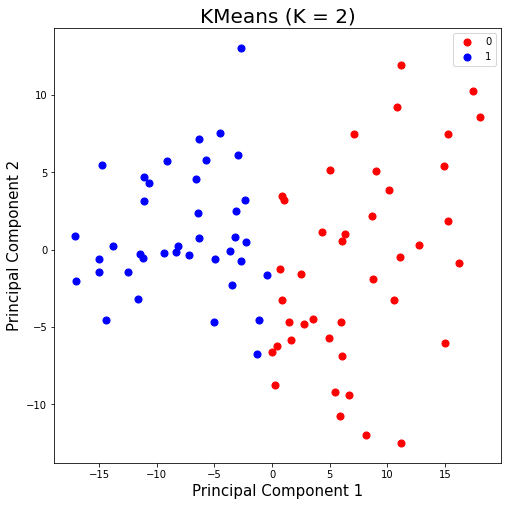

In [38]:
# plot where k = 2 
# best cluster number = 2 via silhouette score

# kmeans: membership is yes or no

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('KMeans (K = 2)', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']

for target, color in zip(targets, colors):
    indicesToKeep = pca_plot_df['KMeans_cluster'] == target
    ax.scatter(pca_plot_df.loc[indicesToKeep, 'principal component 1'], 
               pca_plot_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    ax.legend(targets)

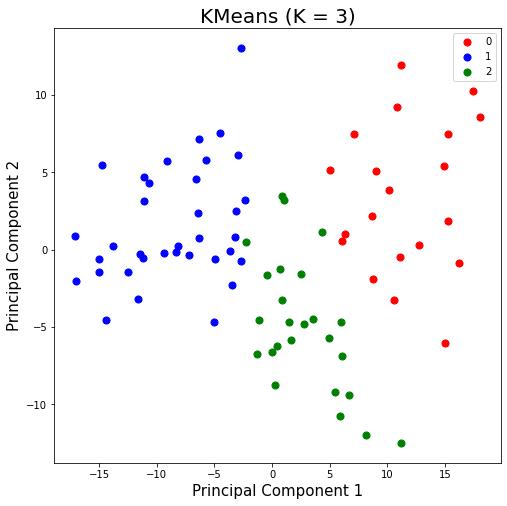

In [40]:
# second best cluster number = 3 via silhouette score

# kmeans where k = 3
clusterer_final3 = KMeans(n_clusters=3)
clusterer_final3 = clusterer_final3.fit(processed_numerical_p50)
processed_p50_plot3 = pd.DataFrame(processed_numerical_p50)
processed_p50_plot3['KMeans_cluster'] = clusterer_final3.labels_
processed_p50_plot3.sort_values('KMeans_cluster',axis=0,inplace=True)
pca_plot_df3 = pd.concat([principalDF, processed_p50_plot3[['KMeans_cluster']]], axis=1)

# plot where k = 3
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('KMeans (K = 3)', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'b', 'g']

for target, color in zip(targets, colors):
    indicesToKeep = pca_plot_df3['KMeans_cluster'] == target
    ax.scatter(pca_plot_df3.loc[indicesToKeep, 'principal component 1'], 
               pca_plot_df3.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    ax.legend(targets)

<AxesSubplot:ylabel='Patient'>

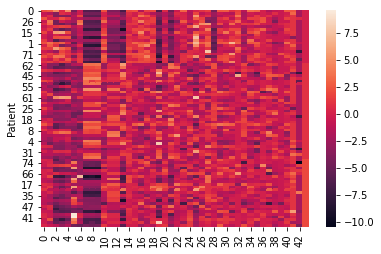

In [42]:
processed_p50_plot3.index.name = 'Patient'
sb.heatmap(processed_p50_plot3)

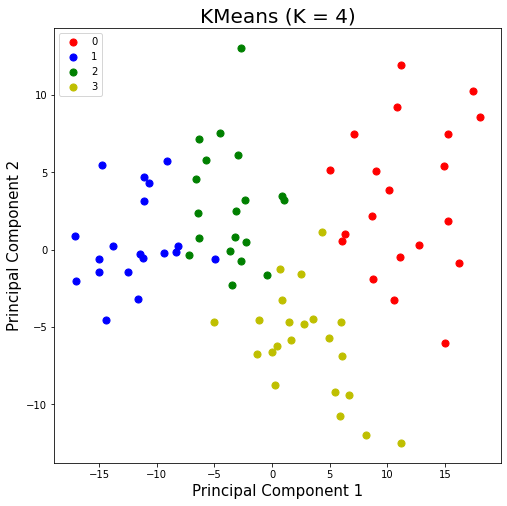

In [43]:
# kmeans where = k = 4
# third best cluster number = 4 via silhouette score

clusterer_final4 = KMeans(n_clusters=4)
clusterer_final4 = clusterer_final4.fit(processed_numerical_p50)
processed_p50_plot4 = pd.DataFrame(processed_numerical_p50)
processed_p50_plot4['KMeans_cluster'] = clusterer_final4.labels_
processed_p50_plot4.sort_values('KMeans_cluster',axis=0,inplace=True)
pca_plot_df4 = pd.concat([principalDF, processed_p50_plot4[['KMeans_cluster']]], axis=1)

# plot where k = 4
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('KMeans (K = 4)', fontsize = 20)
targets = [0, 1, 2, 3]
colors = ['r', 'b', 'g', 'y']

for target, color in zip(targets, colors):
    indicesToKeep = pca_plot_df4['KMeans_cluster'] == target
    ax.scatter(pca_plot_df4.loc[indicesToKeep, 'principal component 1'], 
               pca_plot_df4.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    ax.legend(targets)

<AxesSubplot:ylabel='Patient'>

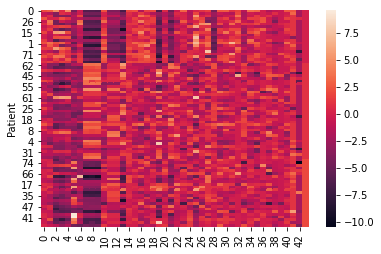

In [44]:
processed_p50_plot3.index.name = 'Patient'
sb.heatmap(processed_p50_plot3)

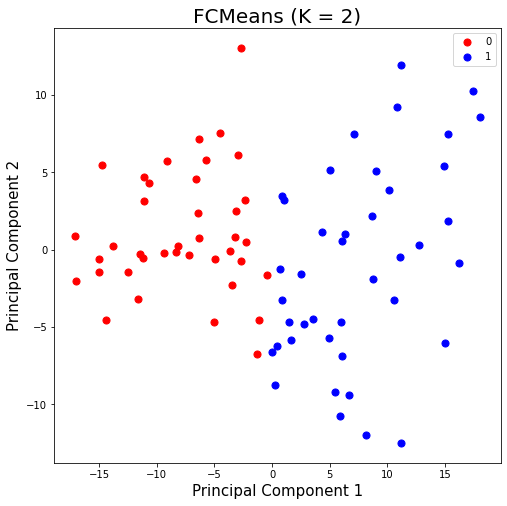

In [45]:
# now lets try fuzzy-c-means (FCM) based on the same cluster numbers
# FCM has possibilistic membership of values to clusters

# FCM k = 2
fcm2 = FCM(n_clusters=2)
fcm2.fit(processed_numerical_p50)
# outputs
fcm2_centers = fcm2.centers
fcm2_labels = fcm2.predict(processed_numerical_p50)
pca_plot_fcm2 = principalDF
pca_plot_fcm2['ClusterNum'] = fcm2_labels.tolist()
# where k = 2
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('FCMeans (K = 2)', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']

for target, color in zip(targets, colors):
    indicesToKeep = pca_plot_fcm2['ClusterNum'] == target
    ax.scatter(pca_plot_fcm2.loc[indicesToKeep, 'principal component 1'], 
               pca_plot_fcm2.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    ax.legend(targets)

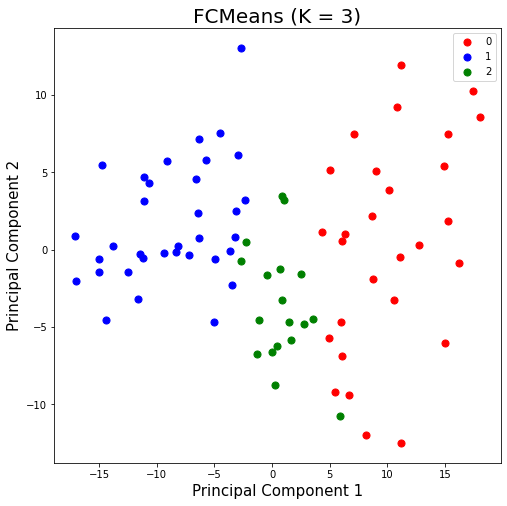

In [46]:
# FCM k = 3
fcm3 = FCM(n_clusters=3)
fcm3.fit(processed_numerical_p50)
# outputs
fcm3_centers = fcm3.centers
fcm3_labels = fcm3.predict(processed_numerical_p50)
pca_plot_fcm3 = principalDF
pca_plot_fcm3['ClusterNum'] = fcm3_labels.tolist()
### Where k = 3
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('FCMeans (K = 3)', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'b', 'g']

for target, color in zip(targets, colors):
    indicesToKeep = pca_plot_fcm3['ClusterNum'] == target
    ax.scatter(pca_plot_fcm3.loc[indicesToKeep, 'principal component 1'], 
               pca_plot_fcm3.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    ax.legend(targets)

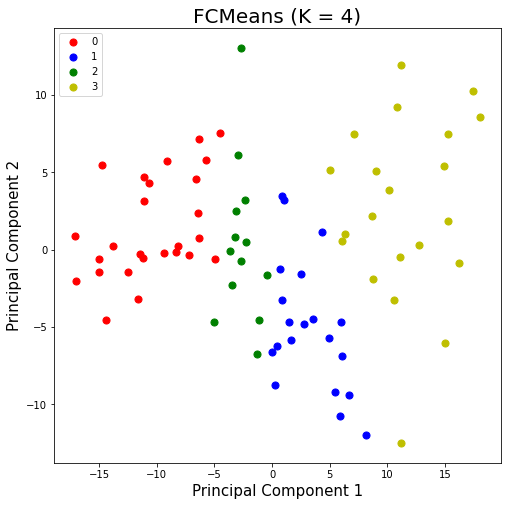

In [47]:
# FCM k = 4
fcm4 = FCM(n_clusters=4)
fcm4.fit(processed_numerical_p50)
# outputs
fcm4_centers = fcm4.centers
fcm4_labels = fcm4.predict(processed_numerical_p50)
pca_plot_fcm4 = principalDF
pca_plot_fcm4['ClusterNum'] = fcm4_labels.tolist()
# where k = 4
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('FCMeans (K = 4)', fontsize = 20)
targets = [0, 1, 2, 3]
colors = ['r', 'b', 'g', 'y']

for target, color in zip(targets, colors):
    indicesToKeep = pca_plot_fcm4['ClusterNum'] == target
    ax.scatter(pca_plot_fcm4.loc[indicesToKeep, 'principal component 1'], 
               pca_plot_fcm4.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    ax.legend(targets)

In [48]:
# differences between KMeans and FCMeans clustering:
# k = 2: KMeans and FCMeans result in the same clusters
# k = 3: KMeans has clearer defined clusters whereas FCMeans has some bleed over and mixed memberships
# k = 4: 2 of the 4 clusters are largely similar between KMeans and FCMeans and the other clusters are different